### MNIST 데이터셋 다운로드

In [20]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np
import torch.optim as optim
import time
import matplotlib.pyplot as plt

batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
test_dataset  = datasets.MNIST('./data', train=False, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

50000 10000 10000


### 통계량 확인 함수

In [3]:
# 이미지의 RGB 채널별 통계량 확인 함수
def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])
    print(f'shape: {imgs.shape}')
    n_channels = imgs.shape[1]  # 채널의 개수
    
    min_r = np.min(imgs, axis=(2, 3))[:, 0].min()
    max_r = np.max(imgs, axis=(2, 3))[:, 0].max()
    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()

    if n_channels == 3:
        min_g = np.min(imgs, axis=(2, 3))[:, 1].min()
        min_b = np.min(imgs, axis=(2, 3))[:, 2].min()

        max_g = np.max(imgs, axis=(2, 3))[:, 1].max()
        max_b = np.max(imgs, axis=(2, 3))[:, 2].max()

        mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
        mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

        std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
        std_b = np.std(imgs, axis=(2, 3))[:, 2].std()
    
    if n_channels == 1:
        print(f'min: {min_r}')
        print(f'max: {max_r}')
        print(f'mean: {mean_r}')
        print(f'std: {std_r}')
    else:
        print(f'min: {min_r, min_g, min_b}')
        print(f'max: {max_r, max_g, max_b}')
        print(f'mean: {mean_r, mean_g, mean_b}')
        print(f'std: {std_r, std_g, std_b}')

In [4]:
print_stats(train_dataset)

shape: (50000, 1, 28, 28)
min: -0.4242129623889923
max: 2.821486711502075
mean: 0.00012341290130279958
std: 0.15455766022205353


### Inspecting Dataset

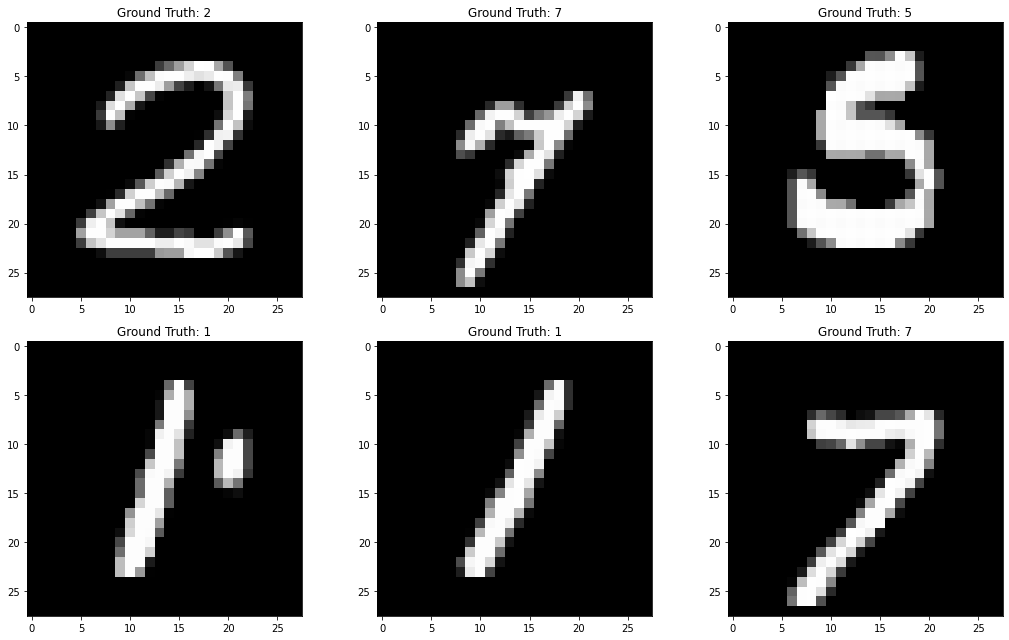

In [21]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title('Ground Truth: {}'.format(example_targets[i]))
plt.show()

### Model Architecture

In [11]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=28*28, out_features=10, bias=True)  # 28*28 = 784

    def forward(self, x):
        x = self.linear(x)
        return x

class MLPModel(nn.Module):
    def __init__(self, n_hdn_units, n_layers):
        super(MLPModel, self).__init__()
        self.n_hdn_units = n_hdn_units
        self.n_layers = n_layers
        self.linear_in  = nn.Linear(in_features=28*28, out_features=self.n_hdn_units)
        self.linear_hdn = nn.Linear(in_features=self.n_hdn_units, out_features=self.n_hdn_units)
        self.linear_out = nn.Linear(in_features=self.n_hdn_units, out_features=10)
        self.relu = nn.ReLU()
        self.n_layers = 0 if self.n_layers < 0 else n_layers    # n_layers < 0 이면 0으로 세팅

    def forward(self, x):
        # Input Layer
        x = self.linear_in(x)
        x = self.relu(x)

        # Hidden Layers
        for i in range(self.n_layers):
            x = self.linear_hdn(x)
            x = self.relu(x)
        
        # Output Layer
        x = self.linear_out(x)
        
        return x



### Loss Function & Optimizer

In [12]:
#model = LinearModel()
n_hdn_units = 200
n_layers = 1
lr = 0.01
model = MLPModel(n_hdn_units, n_layers)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

cls_loss = nn.CrossEntropyLoss()    # Softmax가 포함되어 있음
optimizer = optim.SGD(model.parameters(), lr=lr)

print('Total number of parameters : {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Total number of parameters : 199210


### Train & Evaluation

In [28]:
from sklearn.metrics import accuracy_score

list_epoch = []
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 10
print('Epoch 수 = {}   Hidden Unit 수 = {}   Hidden Layer 수 = {}   LR = {}'.format(epoch, n_hdn_units, n_layers, lr))
for i in range(epoch):
    ts = time.time()
    train_loss = 0
    model.train()

    for input_X, true_y in train_loader:
        optimizer.zero_grad()
        #input_X = input_X.squeeze()        # [128, 1, 28, 28] -> [128, 28, 28]
        #input_X = input_X.view(-1, 784)    # [128, 28, 28] -> [128, 784]
        input_X = input_X.view(-1, 784)    # [128, 1, 28, 28] -> [128,784](squeeze()를 거치지 않아도 됨)
        input_X = input_X.to(device)
        pred_y = model(input_X)
        true_y = true_y.to(device)
        loss = cls_loss(pred_y, true_y)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)     # len(train_loader)는 배치의 개수
    list_train_loss.append(train_loss)
    list_epoch.append(i)

    # Validation
    val_loss = 0
    model.eval()

    with torch.no_grad():
        for input_X, true_y in val_loader:
            input_X = input_X.view(-1, 784)
            input_X = input_X.to(device)
            pred_y = model(input_X)
            true_y = true_y.to(device)
 
            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.item()
        val_loss /= len(val_loader)     # len(train_loader)는 배치의 개수
        list_val_loss.append(val_loss)
    
    # Evaluation
    correct = 0
    model.eval()

    with torch.no_grad():
        for input_X, true_y in test_loader:
            input_X = input_X.view(-1, 784)
            input_X = input_X.to(device)
            pred_y = model(input_X).max(1, keepdim=True).indices.squeeze()    # max()함수는 values와 indices로 나뉜다. [0]은 value, [1]은 indices
            #red_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            true_y = true_y.to(device)
            correct += pred_y.eq(true_y).sum()
        
        acc = correct.item() / len(test_loader.dataset)    # len(test_loader.dataset) : 샘플의 개수
        list_acc.append(acc)
        list_acc_epoch.append(i)

    print('Epoch: {:3d}  Train Loss: {:10.8f}  Val Loss: {:10.8f}  Test Accuracy: {:8.5f}%  Elapse: {:3.3f}'.format(i+1, train_loss, val_loss, acc * 100, time.time()-ts))

Epoch 수 = 10   Hidden Unit 수 = 200   Hidden Layer 수 = 1   LR = 0.01
Epoch:   1  Train Loss: 0.11798303  Val Loss: 0.12391554  Test Accuracy: 96.13000%  Elapse: 12.000
Epoch:   2  Train Loss: 0.11317688  Val Loss: 0.11984380  Test Accuracy: 96.34000%  Elapse: 12.445
Epoch:   3  Train Loss: 0.10817796  Val Loss: 0.11716954  Test Accuracy: 96.51000%  Elapse: 14.403
Epoch:   4  Train Loss: 0.10394845  Val Loss: 0.11424626  Test Accuracy: 96.53000%  Elapse: 12.866
Epoch:   5  Train Loss: 0.09958368  Val Loss: 0.11119736  Test Accuracy: 96.60000%  Elapse: 12.314
Epoch:   6  Train Loss: 0.09581032  Val Loss: 0.10917406  Test Accuracy: 96.62000%  Elapse: 11.975
Epoch:   7  Train Loss: 0.09215915  Val Loss: 0.10651942  Test Accuracy: 96.80000%  Elapse: 11.885
Epoch:   8  Train Loss: 0.08865037  Val Loss: 0.10546039  Test Accuracy: 96.80000%  Elapse: 12.638
Epoch:   9  Train Loss: 0.08536363  Val Loss: 0.10456499  Test Accuracy: 96.79000%  Elapse: 11.693
Epoch:  10  Train Loss: 0.08216541  Val L

### Report Experiment

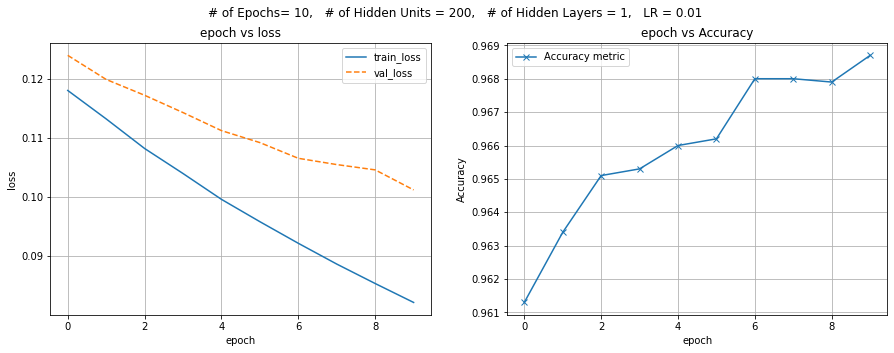

In [30]:
fig = plt.figure(figsize=(15, 5))
fig.suptitle(f'# of Epochs= {epoch},   # of Hidden Units = {n_hdn_units},   # of Hidden Layers = {n_layers},   LR = {lr}', fontsize=12)

# Loss Fluctuation
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# Accuracy Fluctuation
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()